In [1]:
## -- Required packages --:
import time
import statistics
from numpy import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sklearn as sk
import scipy
from scipy.stats import genextreme as gev
import math
import statistics
from numpy import random
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Lambda, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

In [2]:
## Package required to read the Red Sea Data
!pip install pyreadr
import pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.0/416.0 kB 22.8 MB/s eta 0:00:00


In [3]:
def abline(slope, intercept):
    """
    Function to add a straight line to the existing plot
    Arguments:
    * slope
    * intercept
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = 'magenta')

In [4]:
## -- Link with my google drive to call the dataset --:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Non-Gaussian***

###***Rep 1***

## ***Training Set***

In [5]:
Parameter_read_NGP = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Trained-Net/ParameterConfiguration-Jan17-Train-Rep30.RData')
Parameter_read_NGP = np.array(Parameter_read_NGP['storeParameterRep'])
print('Dimension of the Parameter_data', Parameter_read_NGP.shape)

Dimension of the Parameter_data (50000, 3)


In [6]:
Parameter_data_NGP = np.array(Parameter_read_NGP)

shape_vals_NGP = (Parameter_data_NGP[:,0])
awght_vals_NGP = np.log(Parameter_data_NGP[:,1]-4)
lambda_vals_NGP = np.log(Parameter_data_NGP[:,2])

In [7]:
mean_shape = np.mean(shape_vals_NGP)
mean_awght = np.mean(awght_vals_NGP)
mean_lambda = np.mean(lambda_vals_NGP)

sd_shape = np.std(shape_vals_NGP)
sd_awght = np.std(awght_vals_NGP)
sd_lambda = np.std(lambda_vals_NGP)

In [8]:
Y_train_NGP = np.transpose(((shape_vals_NGP - mean_shape)/sd_shape, (awght_vals_NGP - mean_awght)/sd_awght, (lambda_vals_NGP - mean_lambda)/sd_lambda))
print('Shape of Parameter_data_NGP:', Y_train_NGP.shape)

Shape of Parameter_data_NGP: (50000, 3)


In [14]:
shape_train_NGPCS = pd.DataFrame(shape_vals_NGP)
shape_train_NGPCS.describe()

0
count  50000.000000
mean       0.457179
std        0.256520
min        0.010009
25%        0.235989
50%        0.457663
75%        0.680780
max        0.899984

In [15]:
kappa2_train_NGPCS = pd.DataFrame(np.exp(awght_vals_NGP) +4)
kappa2_train_NGPCS.describe()

0
count  50000.000000
mean       4.263058
std        0.439510
min        4.001001
25%        4.006508
50%        4.044366
75%        4.303847
max        5.999882

In [16]:
tau2_train_NGPCS = pd.DataFrame(np.exp(lambda_vals_NGP))
tau2_train_NGPCS.describe()

0
count  50000.000000
mean       0.010820
std        0.020536
min        0.000010
25%        0.000101
50%        0.000993
75%        0.010115
max        0.099991

In [17]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Trained-Net/storeZRep-Jan17-Train-Rep30.RData'


r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'storeZRep' in the R environment
if 'storeZRep' in r_objects:
    my_3d_array = r['storeZRep']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "storeZRep"

Shape of the array: (50000, 256, 30)


In [18]:
numpy_3d_array = numpy_3d_array[:,:,0:1]

In [19]:
import numpy as np
Z_train_NGP_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
  if i % 10000 == 0:
    print(i)

  for j in range(numpy_3d_array.shape[2]):
    slice_mean = np.median(numpy_3d_array[i, :, j])
    slice_std = np.std(numpy_3d_array[i, :, j])

    if slice_std != 0:  #
        Z_train_NGP_std[i, :, j] = (numpy_3d_array[i, :, j] - slice_mean)/slice_std
    else:
        Z_train_NGP_std[i, :, j] = 0

0
10000
20000
30000
40000


In [20]:
Z_train_reshaped_NGP = Z_train_NGP_std.reshape(Z_train_NGP_std.shape[0], 16, 16, 1)
print('Shape of Z_train_reshaped:', Z_train_reshaped_NGP.shape)

Z_train_NGP = np.array(Z_train_reshaped_NGP)
Z_train_NGP.shape

Shape of Z_train_reshaped: (50000, 16, 16, 1)


(50000, 16, 16, 1)

In [21]:
from sklearn.model_selection import train_test_split
x_train_NGP, x_valid_NGP, y_train_NGP, y_valid_NGP = train_test_split(Z_train_NGP, Y_train_NGP, test_size=0.20, shuffle= True)

In [22]:
# del modelRep1
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

# Define the input
input_shape = (16, 16, 1)
inputs = Input(shape=input_shape)

# First Convolutional Block
x = Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=HeNormal())(inputs) # changed from (5,5) # changed from 32 to 64 # , kernel_regularizer=l2(0.001)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Second Convolutional Block
x = Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=HeNormal())(x) # changed from (3,3) # changed from 64 to 128 # , kernel_regularizer=l2(0.001)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x = Dense(units=512, activation="relu", kernel_initializer=HeNormal())(x) # changed from 128
x = Dense(units=10, activation="linear", kernel_initializer=HeNormal())(x)

# Output Layer
output_layer = Dense(units=3, activation="linear")(x)

# Create the model
modelRep1 = Model(inputs=inputs, outputs=output_layer)
modelRep1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,547 (162.29 KB)

 Trainable params: 41,355 (161.54 KB)

 Non-trainable params: 192 (768.00 B)

In [23]:
n_epoch = 100
batch_size = 100 # changed from 200


train_dataset = tf.data.Dataset.from_tensor_slices((x_train_NGP, y_train_NGP)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid_NGP, y_valid_NGP)).batch(batch_size)


# Compile the model
modelRep1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.losses.MeanAbsoluteError(),
                  metrics=[tf.losses.MeanSquaredError()]) # Absolute


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               mode='min',
                               restore_best_weights=True)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=3,
                                         mode='min')

# Training the CNN model
start_time= time.time()

# Assuming train_dataset and valid_dataset are your training and validation data
history = modelRep1.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=n_epoch,
                        batch_size=batch_size,
                        callbacks=[reduce_lr_on_plateau])

print("--- %s seconds ---" % (time.time()-start_time))
time_train = (time.time()-start_time)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.5332 - mean_squared_error: 0.4871 - val_loss: 0.4787 - val_mean_squared_error: 0.4363 - learning_rate: 0.0010
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.4033 - mean_squared_error: 0.2932 - val_loss: 0.3892 - val_mean_squared_error: 0.2916 - learning_rate: 0.0010
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.3882 - mean_squared_error: 0.2753 - val_loss: 0.3743 - val_mean_squared_error: 0.2688 - learning_rate: 0.0010
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.3777 - mean_squared_error: 0.2639 - val_loss: 0.3669 - val_mean_squared_error: 0.2603 - learning_rate: 0.0010
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.3712 - mean_squared_error: 0.2563 - val_loss: 0.3650 - val_mean_squared_error: 0.2564 - learning_rate: 0.0010
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.3647 - mean_squared_error: 0.2492 - val_loss: 0.3691 - val_m

In [24]:
time_train/60

18.240048515796662

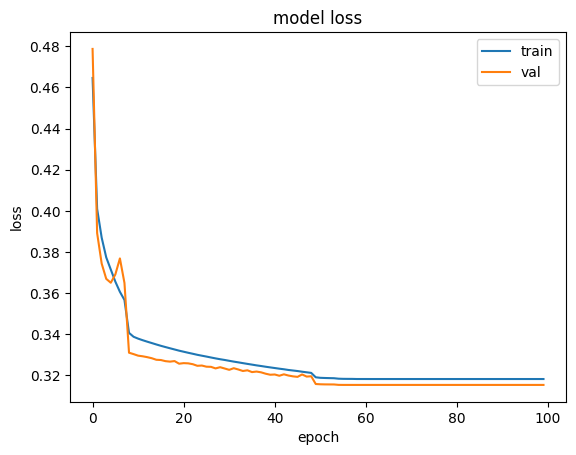

Training loss on the final epoch was: 0.3182


In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print(f"Training loss on the final epoch was: {history.history['loss'][-1]:0.4f}")
plt.show()

In [26]:
# # Save the model - Latest updated Jan 8, 2025
# modelRep1.save('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Trained-Net/CNN-ModelRep1-Jan17-2025.keras')

In [14]:
import tensorflow as tf

# Load the model from the .keras file
modelRep1 = tf.keras.models.load_model('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Trained-Net/CNN-ModelRep1-Jan17-2025.keras')

print("Model loaded successfully.")

# Optionally, print the model summary to confirm it loaded correctly
modelRep1.summary()

Model loaded successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,259 (485.39 KB)

 Trainable params: 41,355 (161.54 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 82,712 (323.10 KB)

In [23]:
train_estimates_NGP = modelRep1.predict(Z_train_NGP)

# loaded_model
train_estimates_NGP = np.array(train_estimates_NGP)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


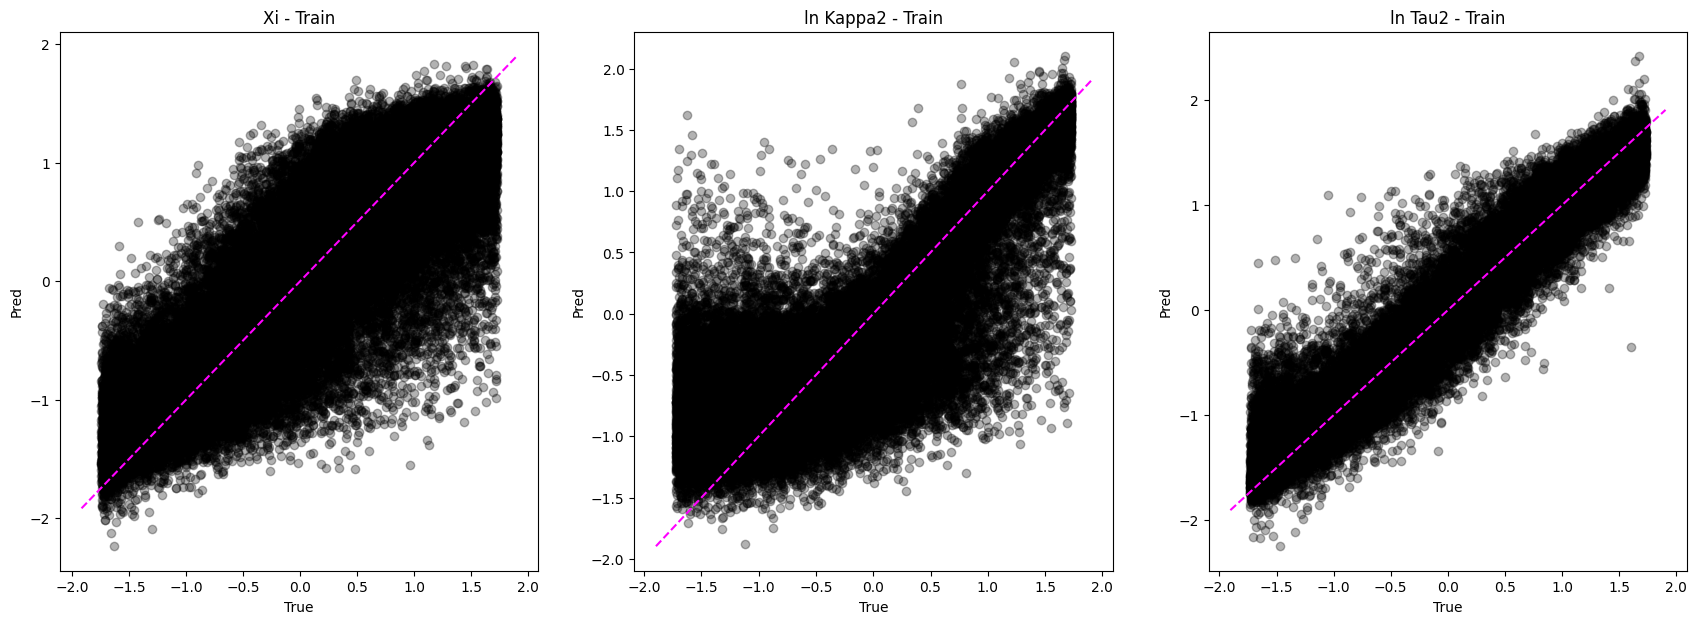

In [24]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_train_NGP[:,0],
            train_estimates_NGP[:,0],
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_train_NGP[:,1]),
            (train_estimates_NGP[:,1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_train_NGP[:,2]),
            (train_estimates_NGP[:,2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [25]:
np.shape(train_estimates_NGP )

(50000, 3)

In [26]:
shape_est_train = train_estimates_NGP[:,0]*sd_shape + mean_shape
awght_est_train =  (train_estimates_NGP[:,1]*sd_awght + mean_awght)
lambda_est_train = (train_estimates_NGP[:,2]*sd_lambda + mean_lambda)

In [27]:
y_est_train = np.transpose((shape_est_train , awght_est_train, lambda_est_train))
print(y_est_train.shape)

(50000, 3)


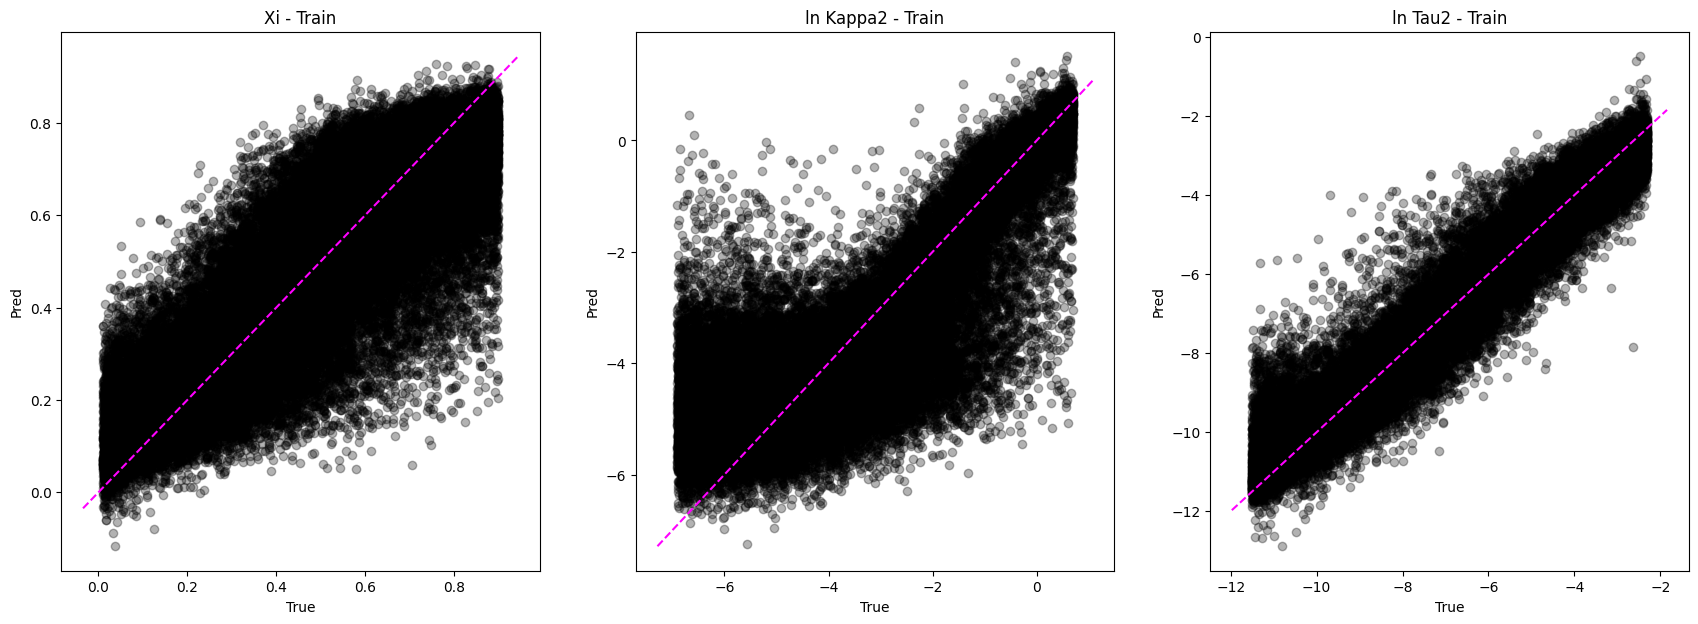

In [28]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_train_NGP[:,0]*sd_shape + mean_shape,
            y_est_train[:,0],
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_train_NGP[:,1]*sd_awght + mean_awght),
            (y_est_train[:,1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_train_NGP[:,2]*sd_lambda + mean_lambda),
            (y_est_train[:,2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [34]:
# Save the array to a .npy file
np.save('trainEstimates-n-1-Latest-Jan17-2025.npy', y_est_train)

### ***Test Set***

In [29]:
## Defining test set - Latest Jan 8, 2025
Parameter_read_NGP_test = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/ParameterConfiguration-Jan22-Test-Rep30-Latest.RData')

Parameter_read_NGP_test = np.array(Parameter_read_NGP_test['parameterComb'])
print('Dimension of the Parameter_data', Parameter_read_NGP_test.shape)

Dimension of the Parameter_data (10000, 3)


In [30]:
shape_vals_NGP_test = (Parameter_read_NGP_test[:,0])
awght_vals_NGP_test = np.log(Parameter_read_NGP_test[:,1]-4)
lambda_vals_NGP_test = np.log(Parameter_read_NGP_test[:,2])


Y_test_NGP = np.transpose(((shape_vals_NGP_test - mean_shape)/sd_shape, (awght_vals_NGP_test - mean_awght)/sd_awght, (lambda_vals_NGP_test - mean_lambda)/sd_lambda))
print(Y_test_NGP.shape)

(10000, 3)


In [31]:
shape_test_NGP = pd.DataFrame(shape_vals_NGP_test)
shape_test_NGP.describe()

0
count  10000.000000
mean       0.501507
std        0.173524
min        0.200091
25%        0.348936
50%        0.501711
75%        0.651778
max        0.799977

In [32]:
awght_test_NGP = pd.DataFrame((awght_vals_NGP_test))
awght_test_NGP.describe()

0
count  10000.000000
mean      -2.030948
std        1.497761
min       -4.603823
25%       -3.323999
50%       -2.043451
75%       -0.726630
max        0.587139

In [33]:
lambda_test_NGP = pd.DataFrame((lambda_vals_NGP_test))
lambda_test_NGP.describe()

0
count  10000.000000
mean      -6.112493
std        1.797365
min       -9.209955
25%       -7.649333
50%       -6.124034
75%       -4.544330
max       -2.996245

In [34]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/storeZRep-Jan22-Test-Rep30-Latest.RData'

r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'storeZRep' in the R environment
if 'extremalFields' in r_objects:
    my_3d_array = r['extremalFields']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "extremalFields" "storeZRep"     

Shape of the array: (10000, 256, 30)


In [35]:
# Reshape the array to (40200, 16, 16, 10)
Z_test_NGP = numpy_3d_array[:, :, 0:1]
print('Shape',  Z_test_NGP.shape)

####
import numpy as np
Z_test_NGP_std = np.empty_like(Z_test_NGP)

for i in range(Z_test_NGP .shape[0]):
  if i % 1000 == 0:  # Correct modulus operator
        print(i)
  for j in range(Z_test_NGP .shape[2]):
    slice_mean = np.median(numpy_3d_array[i, :, j])
    slice_std = np.std(numpy_3d_array[i, :, j])

    if slice_std != 0:  #
        Z_test_NGP_std[i, :, j] = (numpy_3d_array[i, :, j] - slice_mean)/slice_std
    else:
        Z_test_NGP_std[i, :, j] = 0
####

Shape (10000, 256, 1)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [36]:
# Reshape the array to (40200, 16, 16, 10)
Z_test_reshaped_NGP = Z_test_NGP_std.reshape(Z_test_NGP_std.shape[0], 16, 16, 1)

# Check the shape of the reshaped array
print('Shape of Z_test_reshaped:', Z_test_reshaped_NGP.shape)

Z_test_NGP = np.array(Z_test_reshaped_NGP)

# Print max and min values for the first sample in the reshaped array
print('Z_test max:', Z_test_NGP [0,:,:].max())
print('Z_test min:', Z_test_NGP [0,:,:].min())

Z_test_NGP.shape

Shape of Z_test_reshaped: (10000, 16, 16, 1)
Z_test max: 8.703390384386442
Z_test min: -0.7622180847655357


(10000, 16, 16, 1)

In [37]:
test_estimates_NGP =  modelRep1.predict(Z_test_NGP)
test_estimates_NGP = np.array(test_estimates_NGP)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


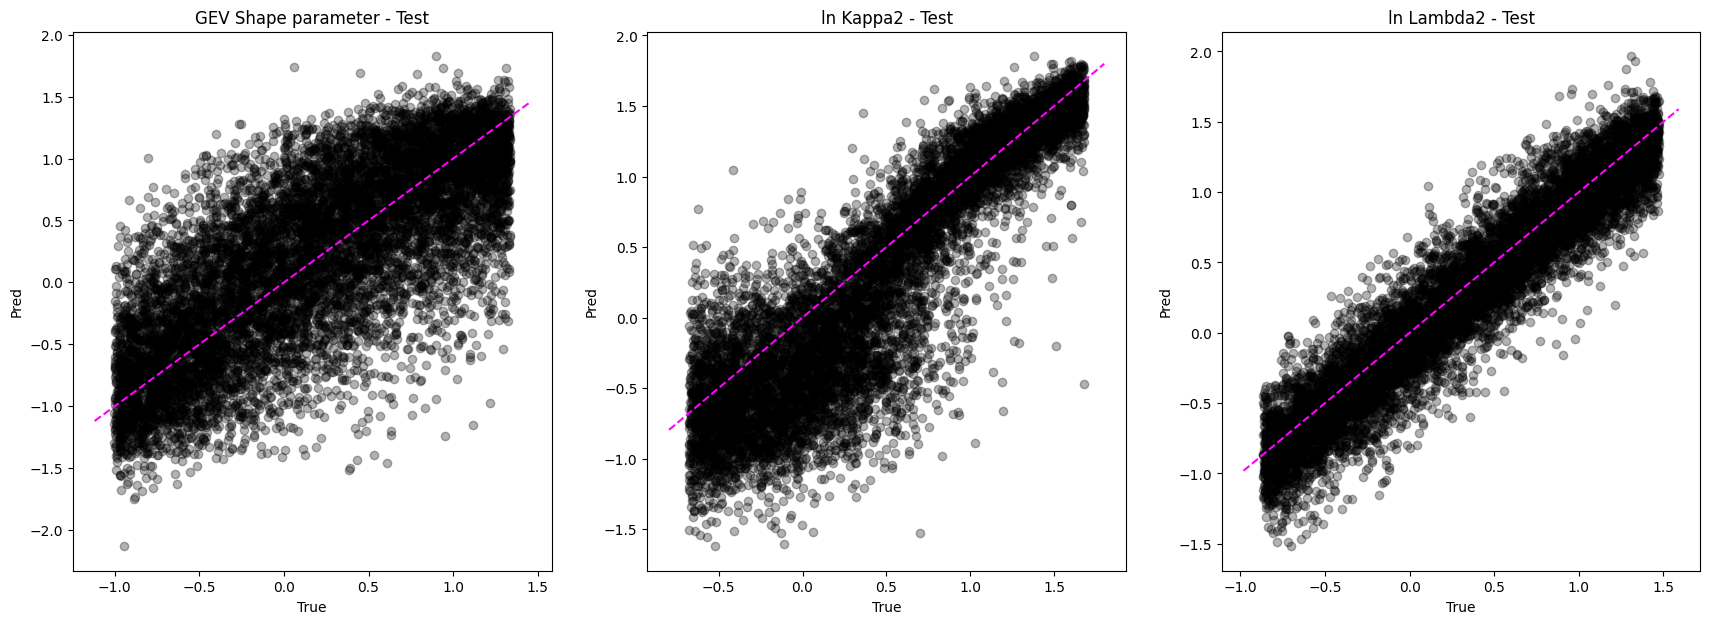

In [38]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_NGP[:,0]),
           (test_estimates_NGP[:,0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1]),
            (test_estimates_NGP[:,1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_NGP[:,2]),
            (test_estimates_NGP[:,2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

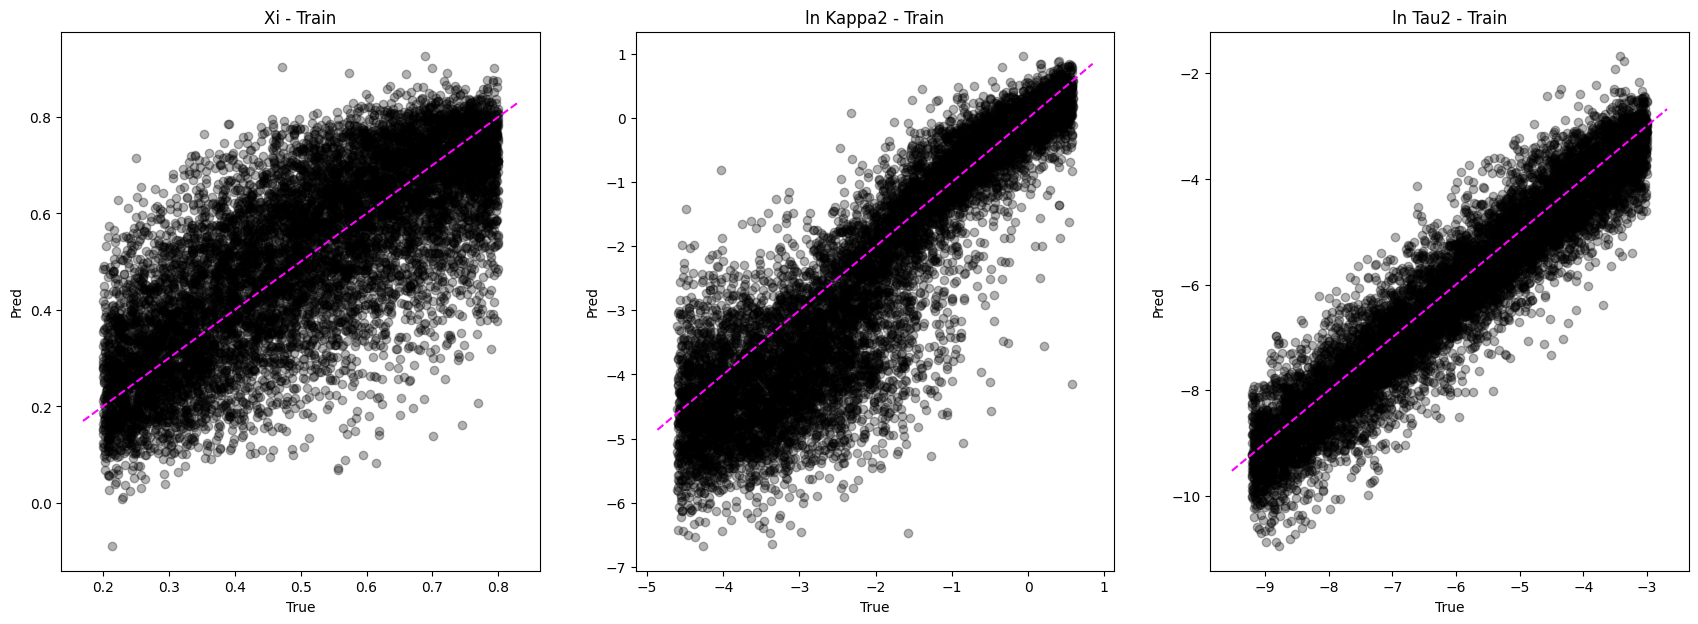

In [39]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_test_NGP[:,0]*sd_shape + mean_shape,
            test_estimates_NGP[:,0]*sd_shape + mean_shape,
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1]*sd_awght + mean_awght),
            (test_estimates_NGP[:,1]*sd_awght + mean_awght),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_NGP[:,2]*sd_lambda + mean_lambda),
            (test_estimates_NGP[:,2]*sd_lambda + mean_lambda),
            color = 'black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

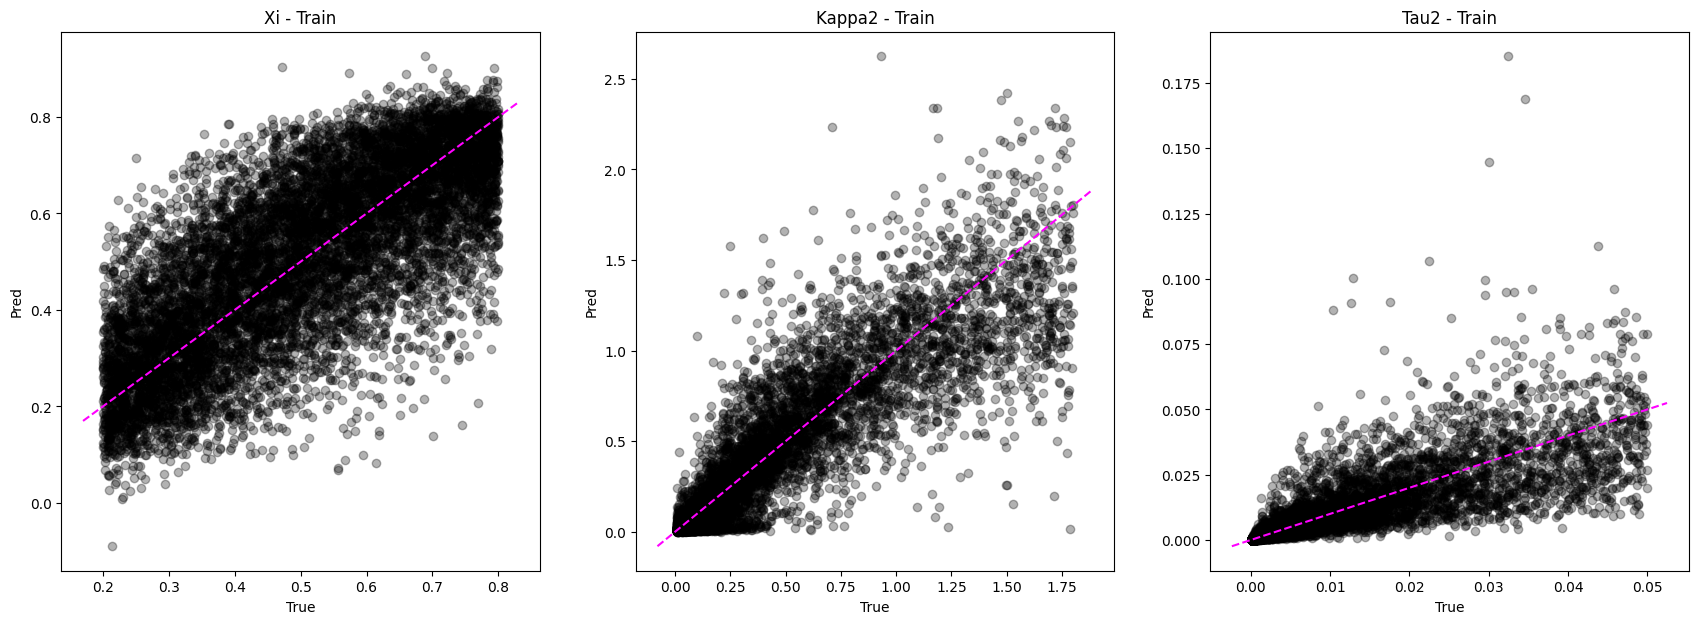

In [40]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_test_NGP[:,0]*sd_shape + mean_shape,
            test_estimates_NGP[:,0]*sd_shape + mean_shape,
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter(np.exp(Y_test_NGP[:,1]*sd_awght + mean_awght),
            np.exp(test_estimates_NGP[:,1]*sd_awght + mean_awght),
            color = 'black',
            alpha=0.3)
plt.title('Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(np.exp(Y_test_NGP[:,2]*sd_lambda + mean_lambda),
            np.exp(test_estimates_NGP[:,2]*sd_lambda + mean_lambda),
            color = 'black',
            alpha=0.3)
plt.title('Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [41]:
shape_test_Est =  test_estimates_NGP[:,0]*sd_shape + mean_shape
a_wght_test_Est = (test_estimates_NGP[:,1]*sd_awght + mean_awght)
lambda_test_Est = (test_estimates_NGP[:,2]*sd_lambda + mean_lambda)

y_test_Est = np.transpose((shape_test_Est, a_wght_test_Est, lambda_test_Est))
print(y_test_Est.shape)

(10000, 3)


In [42]:
np.shape(y_test_Est)

(10000, 3)

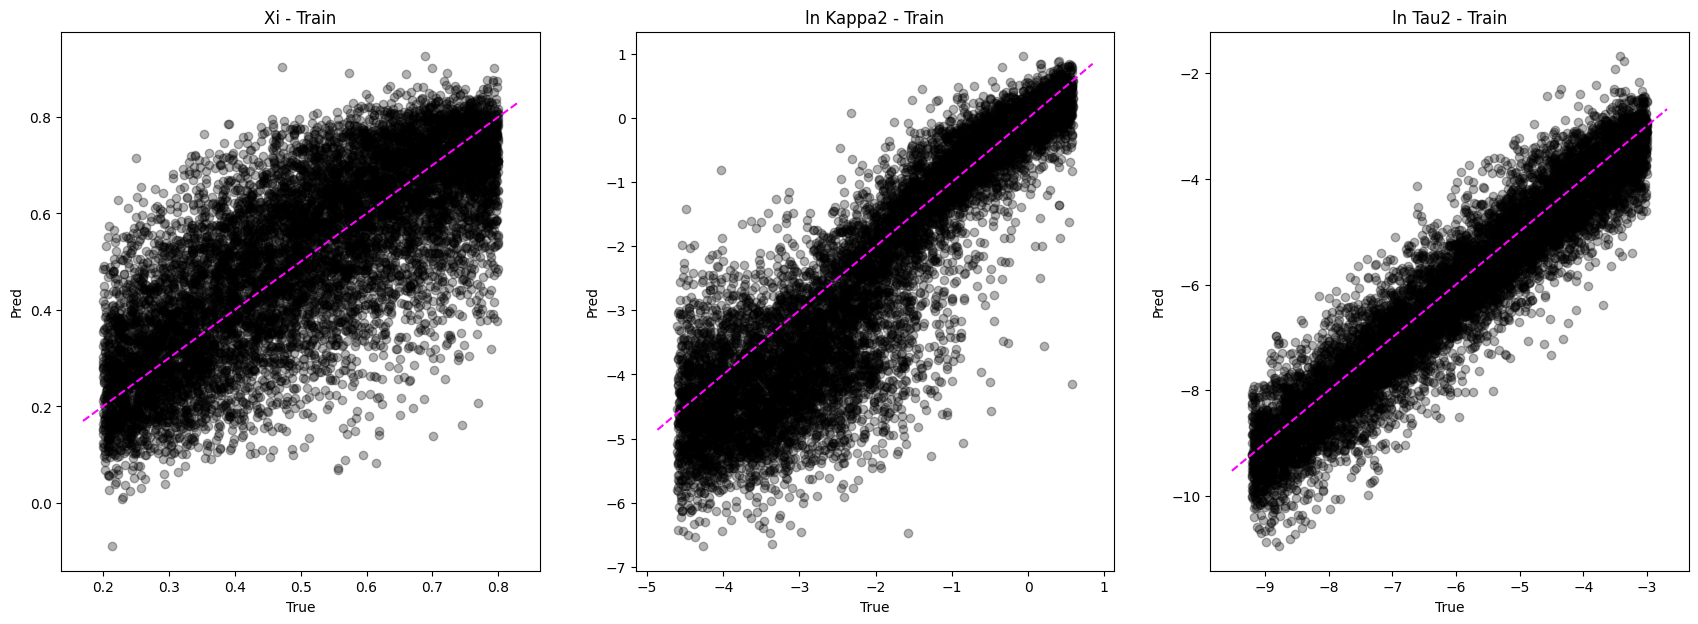

In [43]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_test_NGP[:,0]*sd_shape + mean_shape,
            y_test_Est[:,0],
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1]*sd_awght + mean_awght),
            y_test_Est[:,1],
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_NGP[:,2]*sd_lambda + mean_lambda),
            y_test_Est[:,2],
            color = 'black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [44]:
# Save the array to a .npy file
np.save('test_estimates_NGP-n-1-Latest-Jan17-2025.npy', y_test_Est)

In [ ]:
# np.savetxt("test_estimates_NGP-Latest-1000.csv", test_estimates_NGP, delimiter=",")

##  ***Test set with replication***

In [9]:
## Defining test set - Latest Jan 8, 2025
Parameter_read_NGP_test_Rep = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/ParameterConfiguration-Jan27-Test-Rep30-PC-Rep100-Ltst.RData')

Parameter_read_NGP_test_Rep = np.array(Parameter_read_NGP_test_Rep['parameterComb'])
print('Dimension of the Parameter_data', Parameter_read_NGP_test_Rep.shape)

Dimension of the Parameter_data (1000, 3)


In [10]:
shape_vals_NGP_test = (Parameter_read_NGP_test_Rep[:,0])
awght_vals_NGP_test = np.log(Parameter_read_NGP_test_Rep[:,1]-4)
lambda_vals_NGP_test = np.log(Parameter_read_NGP_test_Rep[:,2])

Y_test_NGP = np.transpose(( (shape_vals_NGP_test-mean_shape)/sd_shape, (awght_vals_NGP_test - mean_awght)/sd_awght, (lambda_vals_NGP_test-mean_lambda)/sd_lambda))
print(Y_test_NGP.shape)

(1000, 3)


In [11]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/storeZRep-Jan27-Test-Rep30-PC-Rep100-Ltst.RData'
r['load'](rdata_file)

# List the objects
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'extremalFields'
if 'extremalFields' in r_objects:
    my_3d_array = r['extremalFields']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "extremalFields"

Shape of the array: (1000, 60, 256, 30)


In [13]:
import numpy as np
print('Dim: ', numpy_3d_array.shape)
Z_test_NGP_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
  if i % 100 == 0:  # Correct modulus operator
        print(i)
  for j in range(numpy_3d_array.shape[1]):
    for k in range(numpy_3d_array.shape[3]):
      slice_mean = np.median(numpy_3d_array[i, j, :, k])
      slice_std = np.std(numpy_3d_array[i, j, :, k])
      if slice_std != 0:
         Z_test_NGP_std[i, j, :, k] = (numpy_3d_array[i, j, :, k] - slice_mean)/slice_std
    else:
        Z_test_NGP_std[i, j, :, k] = 0

Dim:  (1000, 60, 256, 30)
0
100
200
300
400
500
600
700
800
900


In [15]:
Z_test_NGP_std = Z_test_NGP_std[:, :, :, 0:1]
Z_test = Z_test_NGP_std.reshape(Z_test_NGP_std.shape[0], Z_test_NGP_std.shape[1], 16, 16, 1)

# Check the shape of the reshaped array
print('Shape of Z_test_reshaped:', Z_test.shape)

Z_test_NGP = np.array(Z_test)

# Print max and min values for the first sample in the reshaped array
print('Z_test max:', Z_test[0, :, :, :].max())
print('Z_test min:', Z_test[0, :, :, :].min())

Z_test.shape

Shape of Z_test_reshaped: (1000, 60, 16, 16, 1)
Z_test max: 5.661334888601879
Z_test min: -2.7214248979029305


(1000, 60, 16, 16, 1)

In [16]:
est_parameter_testRep = np.empty((Z_test.shape[0], Z_test.shape[1], 3))
print('Check the dimension: ', np.shape(est_parameter_testRep))

for i in range(est_parameter_testRep.shape[0]):
  est_parameter_testRep[i, :, :] = np.array(modelRep1.predict(Z_test[i, :, :, :]))

Check the dimension:  (1000, 60, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━

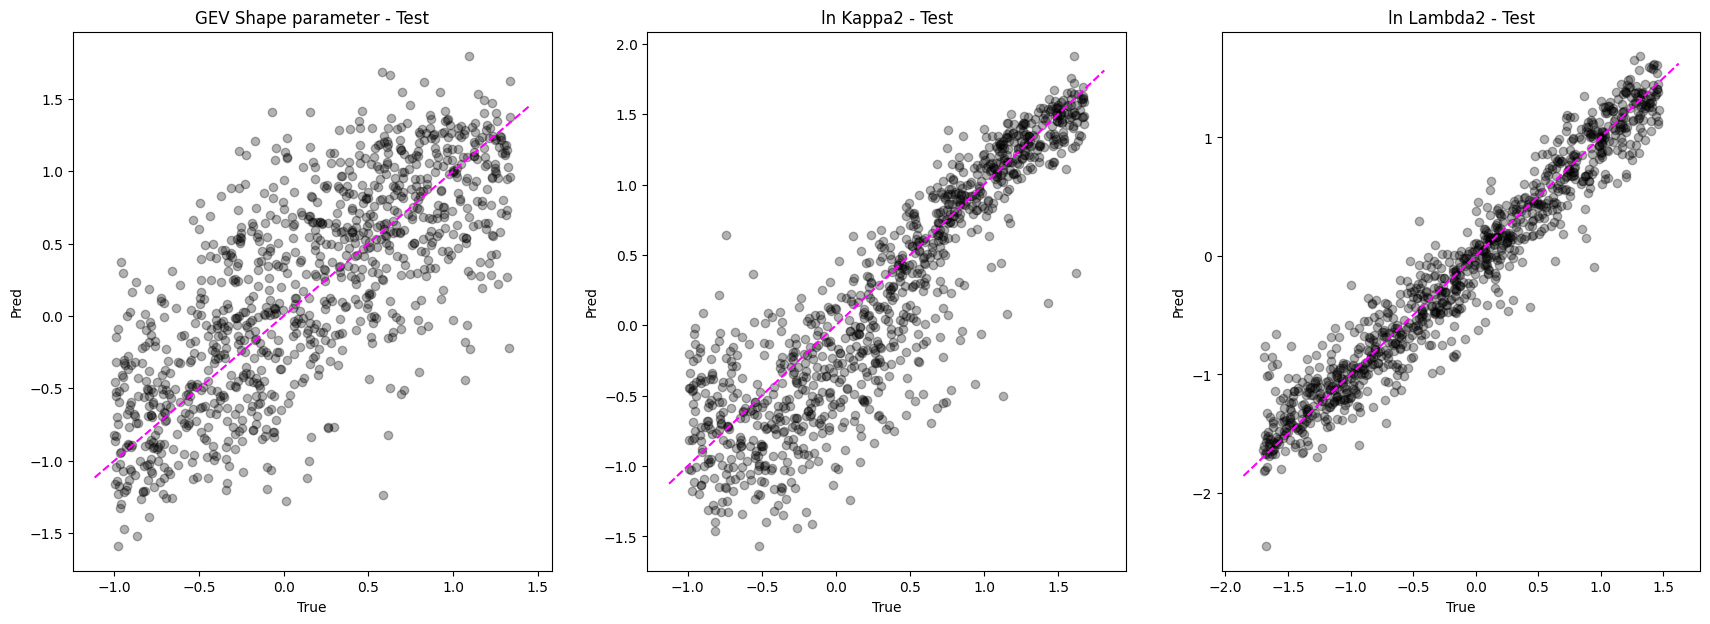

In [17]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_NGP[:,0]),
           (est_parameter_testRep[:, 10, 0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1]),
             (est_parameter_testRep[:, 10, 1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(Y_test_NGP[:,2],
            est_parameter_testRep[:,10, 2],
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [18]:
est_parameter_testRep.shape

(1000, 60, 3)

In [19]:
# Assuming est_parameter_testRep has shape (1000, 60, 3)
shape_est_test = est_parameter_testRep[:, :, 0] * sd_shape + mean_shape
awght_est_test = est_parameter_testRep[:, :, 1] * sd_awght + mean_awght
lambda_est_test = est_parameter_testRep[:, :, 2] * sd_lambda + mean_lambda

# Stack them back along the last axis to maintain (1000, 60, 3)
est_parameter_testRep1 = np.stack((shape_est_test, awght_est_test, lambda_est_test), axis=-1)

print(est_parameter_testRep1.shape)

(1000, 60, 3)


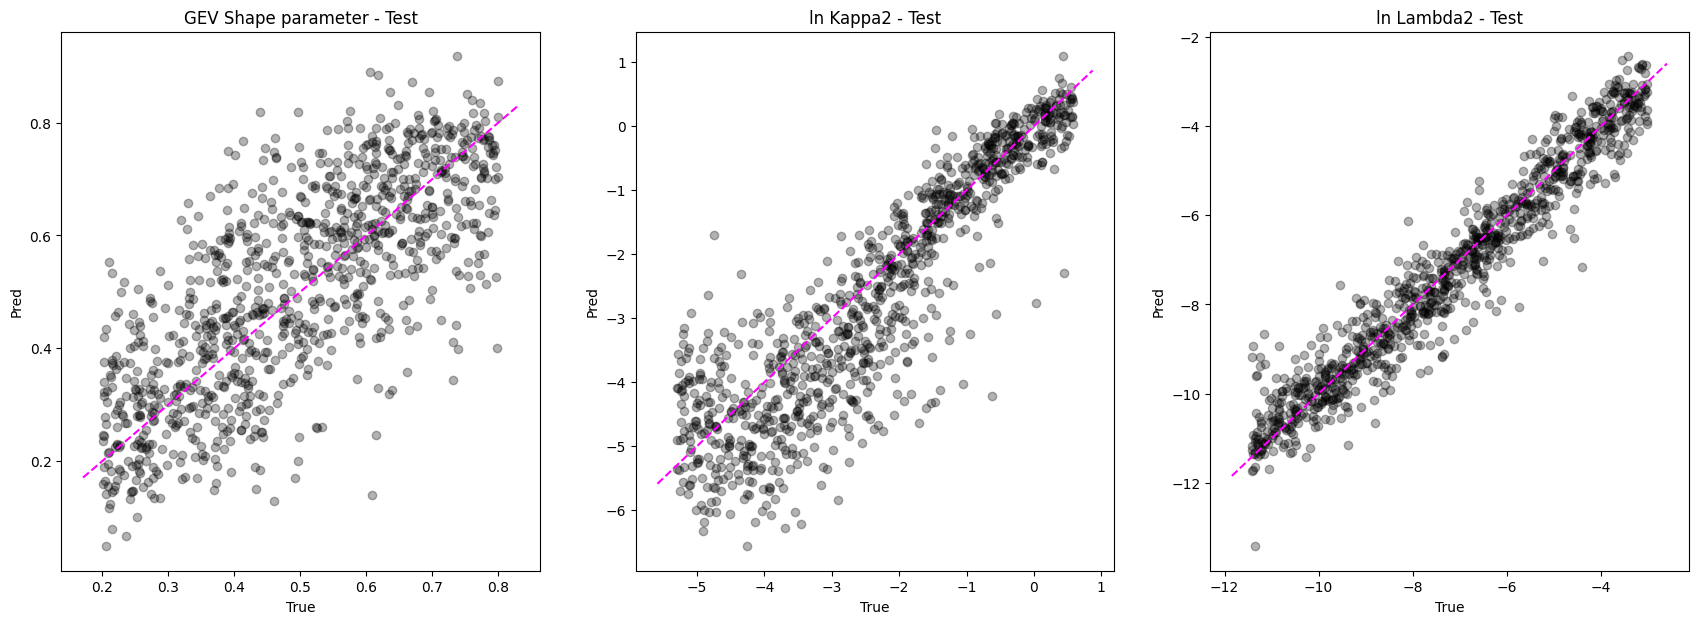

In [20]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_NGP[:,0])* sd_shape + mean_shape,
           (est_parameter_testRep1[:, 10, 0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1])* sd_awght + mean_awght,
             (est_parameter_testRep1[:, 10, 1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(Y_test_NGP[:,2]* sd_lambda + mean_lambda,
            est_parameter_testRep1[:,10, 2],
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [21]:
## Saving test data set across replication:
print(est_parameter_testRep1.shape)
np.save("est_parameter_testRep1-RepAcrossPC60.npy", est_parameter_testRep1)

(1000, 60, 3)


## ***Evaluate test set: for comparison with likelihood estimation***

In [9]:
## Defining test set - Latest Jan 8, 2025
Parameter_read_ML_test = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/MLE/TruePar-NoNugget-LikComp-01-28-25-Test.RData')

Parameter_read_ML_test = np.array(Parameter_read_ML_test['parameterComb'])
print('Dimension of the Parameter_data', Parameter_read_ML_test.shape)

Dimension of the Parameter_data (1024, 3)


In [11]:
shape_vals_ML_test = (Parameter_read_ML_test[:,0])
awght_vals_ML_test = np.log(Parameter_read_ML_test[:,1]-4)
lambda_vals_ML_test = np.log(Parameter_read_ML_test[:,2])

Y_test_ML = np.transpose(((shape_vals_ML_test - mean_shape)/sd_shape, (awght_vals_ML_test - mean_awght)/sd_awght, (lambda_vals_ML_test - mean_lambda)/sd_lambda))
print(Y_test_ML.shape)

(1024, 3)


In [12]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/MLE/storeZRep30-NoNugget-LikComp-01-28-25-Test.RData'
r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

if 'extremalFields' in r_objects:
    my_3d_array = r['extremalFields']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "extremalFields"

Shape of the array: (1024, 256, 30)


In [13]:
import numpy as np
Z_test_ML_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
  if i % 1000 == 0:  # Correct modulus operator
        print(i)

  for j in range(numpy_3d_array.shape[2]):
    slice_mean = np.median(numpy_3d_array[i, :, j])
    slice_std = np.std(numpy_3d_array[i, :, j])

    if slice_std != 0:  #
        Z_test_ML_std[i, :, j] = (numpy_3d_array[i, :, j] - slice_mean)/slice_std
    else:
        Z_test_ML_std[i, :, j] = 0

0
1000


In [16]:
Z_test_ML_std_N = Z_test_ML_std[ :, :, 0]
Z_test_reshaped_ML = Z_test_ML_std_N.reshape(Z_test_ML_std_N.shape[0], 16, 16, 1) # (Z_test_NGP.shape[0], 100, 16, 16, 30)
Z_test_ML = np.array(Z_test_reshaped_ML)

# Print max and min values for the first sample in the reshaped array
print('Z_test max:', Z_test_ML[0,:,:].max())
print('Z_test min:', Z_test_ML[0,:,:].min())

Z_test_ML.shape

Z_test max: 1.5807735459782921
Z_test min: -2.9280817324643342


(1024, 16, 16, 1)

In [17]:
test_estimates_ML = modelRep1.predict(Z_test_ML)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


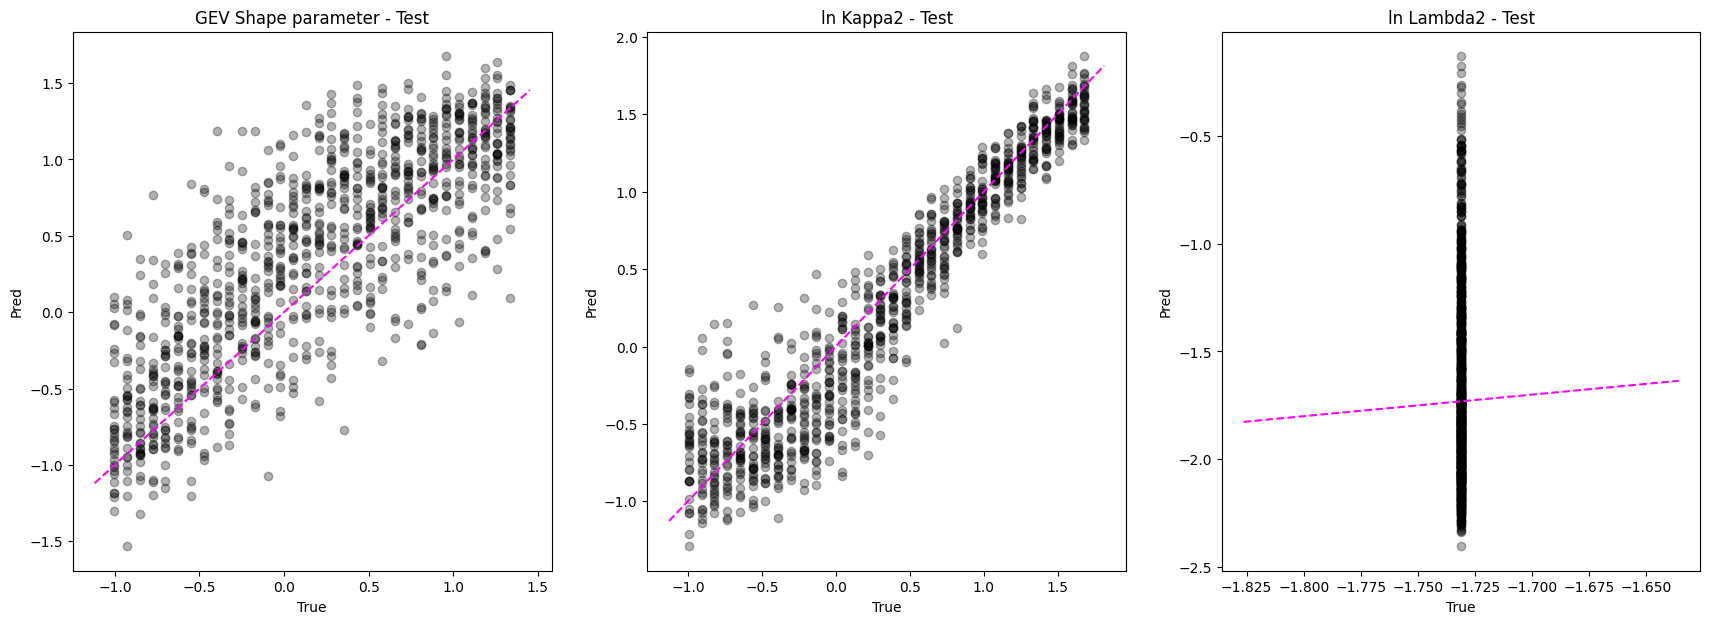

In [18]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_ML[:, 0]),
            (test_estimates_ML[:, 0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_ML[:,1]),
            (test_estimates_ML[:,  1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_ML[:,2]),
            (test_estimates_ML[:, 2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [19]:
import numpy as np

# Assuming test_estimates_ML has shape (1000, 60, 3)
shape_est_test = test_estimates_ML[:, 0] * sd_shape + mean_shape
awght_est_test = test_estimates_ML[:, 1] * sd_awght + mean_awght  # Removed comma
lambda_est_test = test_estimates_ML[:, 2] * sd_lambda + mean_lambda

# Stack along the last axis to maintain shape (1000, 60, 3)
est_parameter_testMLRep1 = np.stack([shape_est_test, awght_est_test, lambda_est_test], axis=-1)

# Check the shape
print("Final shape:", est_parameter_testMLRep1.shape)  # Should be (1000, 60, 3)

Final shape: (1024, 3)


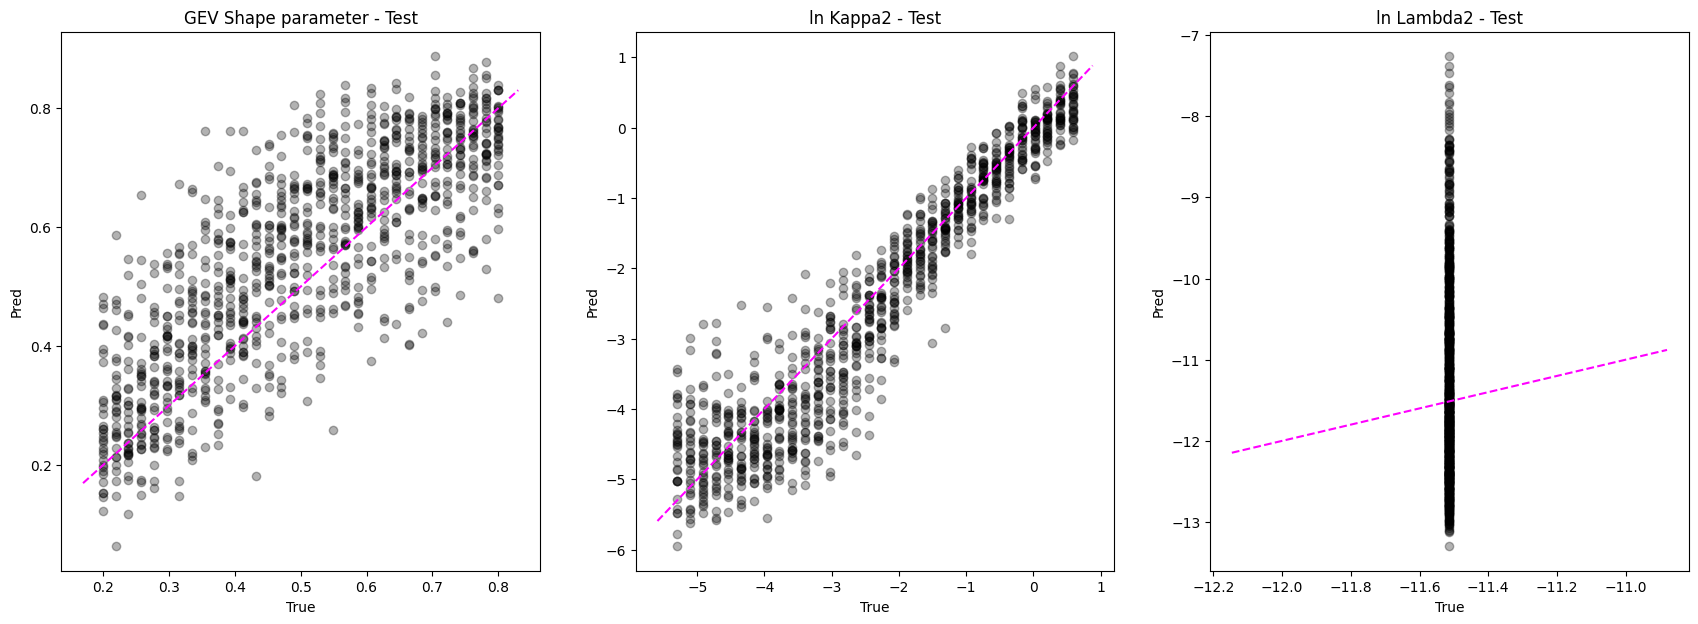

In [20]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_ML[:,0]* sd_shape + mean_shape),
            est_parameter_testMLRep1[:,0],
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_ML[:,1]* sd_awght + mean_awght),
            est_parameter_testMLRep1[:,1],
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_ML[:,2]* sd_lambda + mean_lambda),
            est_parameter_testMLRep1[:,2],
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [21]:
est_parameter_testMLRep1.shape

(1024, 3)

In [23]:
# Save the array to a .npy file
np.save('testEst-ML-n-1-Latest-01-28-25.npy', est_parameter_testMLRep1)

## ***Red Sea***

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/annual_max_across_16x16boxes.RData'
# LatestStorage/storeZRep5-PositiveShape-0.01-1-Test-RandomlySample.RData'
#
#
r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'storeZRep' in the R environment
if 'annual_max_across_16x16boxes' in r_objects:
    my_3d_array = r['annual_max_across_16x16boxes']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "annual_max_across_16x16boxes" "storeZRep"                   
[3] "storeZRepTrain"               "storeZRepValid"              

Shape of the array: (27, 16, 16, 30)


In [ ]:
# Reshape the array to (40200, 16, 16, 10)
Z_test_NGP = numpy_3d_array
Z_test_reshaped_NGP = Z_test_NGP.reshape(Z_test_NGP.shape[0], 16, 16, 30)
# Z_test_reshaped_NGP = Z_test_reshaped_NGP[(index_working_test== False), :, :,:]

# Check the shape of the reshaped array
print('Shape of Z_test_reshaped:', Z_test_reshaped_NGP.shape)

Z_test_NGP = np.array(Z_test_reshaped_NGP)

# Print max and min values for the first sample in the reshaped array
print('Z_test max:', Z_test_NGP [0,:,:].max())
print('Z_test min:', Z_test_NGP [0,:,:].min())

Z_test_NGP.shape

Shape of Z_test_reshaped: (27, 16, 16, 30)
Z_test max: 1.0
Z_test min: 0.0


(27, 16, 16, 30)